# Modeling and Simulation in Python

Chapter 6

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [3]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

### Code from the previous chapter



In [5]:
filename = '/home/bonzilla/Desktop/MSDS2020/DATA604_SimPy/ModSimPy/ModSimPy/notebooks/data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [6]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [7]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

In [8]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
elapsed_time = t_end - t_0

p_0 = get_first_value(census)
p_end = get_last_value(census)
total_growth = p_end - p_0

annual_growth = total_growth / elapsed_time

0.07224800083333333

### System objects

We can rewrite the code from the previous chapter using system objects.

In [9]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
annual_growth,0.072248


And we can encapsulate the code that runs the model in a function.

In [10]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

We can also encapsulate the code that plots the results.

In [11]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Here's how we run it.

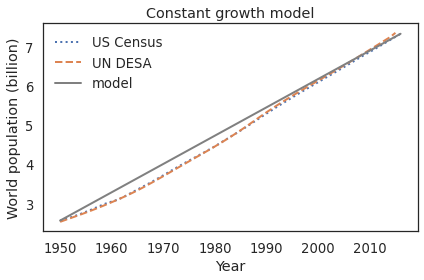

In [12]:
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

## Proportional growth

Here's a more realistic model where the number of births and deaths is proportional to the current population.

In [13]:
def run_simulation2(system):
    """Run a model with proportional birth and death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

I picked a death rate that seemed reasonable and then adjusted the birth rate to fit the data.

In [14]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

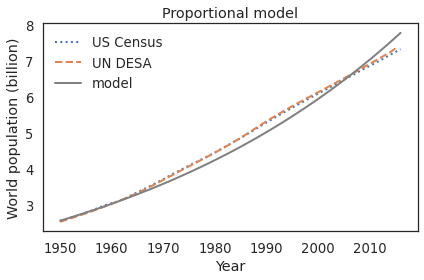

In [16]:
results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')
#savefig('figs/chap06-fig01.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

### Factoring out the update function

`run_simulation1` and `run_simulation2` are nearly identical except the body of the loop.  So we can factor that part out into a function.

In [28]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    print( 'pop: ', round(pop,2), '\tt: ', t )
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

The name `update_func` refers to a function object.

In [18]:
update_func1

<function __main__.update_func1(pop, t, system)>

Which we can confirm by checking its type.

In [19]:
type(update_func1)

function

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [24]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system);
        
    return results

Here's how we use it.

In [21]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=0.027,
                death_rate=0.01)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
birth_rate,0.027000
death_rate,0.010000


pop:  2.56 	t:  1950
pop:  2.6 	t:  1951
pop:  2.65 	t:  1952
pop:  2.69 	t:  1953
pop:  2.74 	t:  1954
pop:  2.78 	t:  1955
pop:  2.83 	t:  1956
pop:  2.88 	t:  1957
pop:  2.93 	t:  1958
pop:  2.98 	t:  1959
pop:  3.03 	t:  1960
pop:  3.08 	t:  1961
pop:  3.13 	t:  1962
pop:  3.18 	t:  1963
pop:  3.24 	t:  1964
pop:  3.29 	t:  1965
pop:  3.35 	t:  1966
pop:  3.41 	t:  1967
pop:  3.46 	t:  1968
pop:  3.52 	t:  1969
pop:  3.58 	t:  1970
pop:  3.64 	t:  1971
pop:  3.71 	t:  1972
pop:  3.77 	t:  1973
pop:  3.83 	t:  1974
pop:  3.9 	t:  1975
pop:  3.96 	t:  1976
pop:  4.03 	t:  1977
pop:  4.1 	t:  1978
pop:  4.17 	t:  1979
pop:  4.24 	t:  1980
pop:  4.31 	t:  1981
pop:  4.39 	t:  1982
pop:  4.46 	t:  1983
pop:  4.54 	t:  1984
pop:  4.61 	t:  1985
pop:  4.69 	t:  1986
pop:  4.77 	t:  1987
pop:  4.85 	t:  1988
pop:  4.94 	t:  1989
pop:  5.02 	t:  1990
pop:  5.11 	t:  1991
pop:  5.19 	t:  1992
pop:  5.28 	t:  1993
pop:  5.37 	t:  1994
pop:  5.46 	t:  1995
pop:  5.55 	t:  1996
pop:  5.65 	t:  

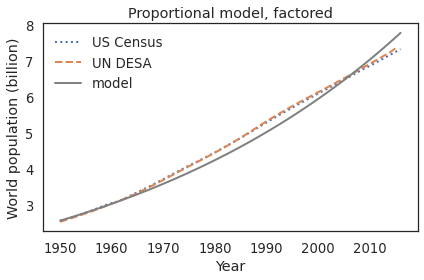

In [33]:
results = run_simulation(system, update_func1);
plot_results(census, un, results, 'Proportional model, factored');

Remember not to put parentheses after `update_func1`.  What happens if you try? *a type error*

**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t_0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [34]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha  * pop
    return pop + net_growth

Here's how it works:

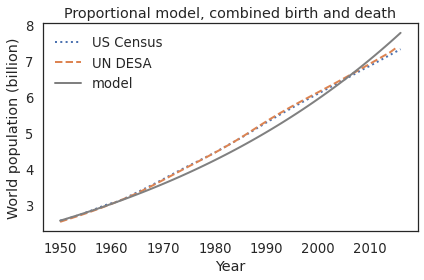

In [35]:
system.alpha = system.birth_rate - system.death_rate

results = run_simulation(system, update_func2)
plot_results(census, un, results, 'Proportional model, combined birth and death')

### Exercises

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an update function that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.  Note: Don't forget the `return` statement.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.



In [42]:
# Solution goes here
def update_func3(pop, t, system):
    """Compute the population next year with 2 different growth rates.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    #print( t )
    if t <= 1980:
        #print( 'early' )
        net_growth = system.alpha1  * pop
    else:
        #print( 'late')
        net_growth = system.alpha2  * pop
    return pop + net_growth

In [59]:
# Solution goes here
system.alpha1 = 0.019
system.alpha2 = 0.014

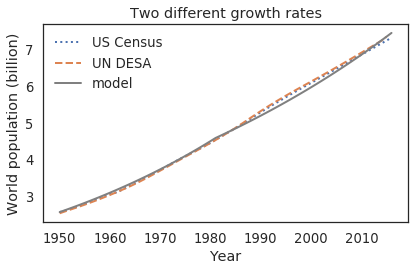

In [60]:
results = run_simulation(system, update_func3)
plot_results(census, un, results, 'Two different growth rates')

it makes total sense that the data is better fit by a more rapid growth before 1980 and a less rapid growth after 1980. because: baby boomers.